In [4]:
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torchvision import transforms, datasets

from classifiers.NerveNet_GAN import NerveNET, BinaryOut, Discriminator
from data_utils_NerveNet import SegmentationData
from solver_NerveNet_GAN import Solver
from solver_NerveNet import Solver as SolverBinary
import transform_utils_NerveNet as tu
from dice_loss import DiceLoss

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define and Divide Dataset
The following calculates the **sizes of train, validation and test set**. Make sure it returns **True** by modifying the values in the dictionary 'nums'.

In [5]:
img_files = 'image_files.txt' 
num_lines = sum(1 for line in open(img_files, 'r'))
num_lines = sum(1 for line in open(img_files, 'r'))
nums = {'num_train' : int(0.6*num_lines)+2,
        'num_val'   : int(0.2*num_lines),
        'num_test' : int(0.2*num_lines)}

print(nums, num_lines)
print(np.sum(list(nums.values())) == num_lines)

{'num_train': 1278, 'num_val': 425, 'num_test': 425} 2128
True


### 1. Train Nervenet without binary influence on dataset that contains only masked images.
Therefore, freeze all weights of model.binary and set train_data argument mask_only to true. The idea behind this is that the encoding stage can properly find filters for detecting nerves.

#### 1.1 Freeze Binary Output and Encoder Layers.

In [6]:
input_dim = (1, 128, 128)
model = torch.load("models/NerveNet+b_best.model", map_location=lambda storage, loc: storage)
#model = NerveNET(input_dim, weight_scale = True)
#model = torch.load("models/SegNet.model")
#model.binary_out = True

/usr/lib64/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'classifiers.NerveNet.NerveNET' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [7]:
discr_model = Discriminator(input_dim, weight_scale = True, dropout = 0.05)

#### 1.2 Initialize Dataloader with masked images only

In [8]:
input_dim = (1, 128, 128)
#be aware about how these are set
binary_out = True 
mask_only = True

train_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.RandomHorizontalFlip(),
                               tu.RandomVerticalFlip(),                               
                               tu.ToTensor()])

val_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.ToTensor()])


train_data = SegmentationData(img_files, transform = train_transforms, mode = 'train', **nums, 
                              binary_out = binary_out, mask_only = mask_only)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=3,
                                           shuffle=True,
                                           num_workers=2)

val_data = SegmentationData(img_files,  transform = val_transforms, mode = 'val', **nums)
val_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=3,
                                           shuffle=True,
                                           num_workers=2)

#### 1.3 Train Classifier

START TRAIN.
|Iteration 10/2130| TRAIN loss NNG/DISCR: 0.297 / 0.523 || DISCRout REAL / FAKE / NNG: 0.429 / 0.438 / 0.452


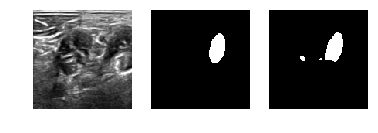

|Iteration 20/2130| TRAIN loss NNG/DISCR: 0.273 / 0.462 || DISCRout REAL / FAKE / NNG: 0.581 / 0.505 / 0.545


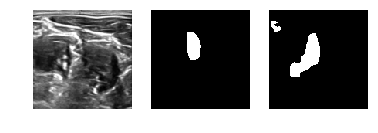

|Iteration 30/2130| TRAIN loss NNG/DISCR: 0.350 / 0.512 || DISCRout REAL / FAKE / NNG: 0.397 / 0.352 / 0.327


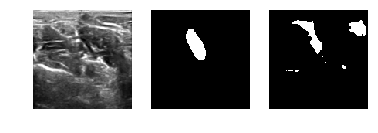

|Iteration 40/2130| TRAIN loss NNG/DISCR: 0.339 / 0.526 || DISCRout REAL / FAKE / NNG: 0.643 / 0.623 / 0.466


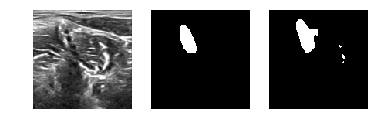

|Iteration 50/2130| TRAIN loss NNG/DISCR: 0.377 / 0.696 || DISCRout REAL / FAKE / NNG: 0.610 / 0.704 / 0.558


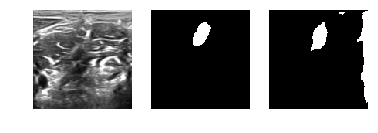

|Iteration 60/2130| TRAIN loss NNG/DISCR: 0.509 / 0.412 || DISCRout REAL / FAKE / NNG: 0.641 / 0.401 / 0.244


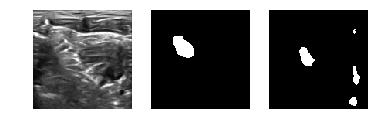

|Iteration 70/2130| TRAIN loss NNG/DISCR: 0.399 / 0.495 || DISCRout REAL / FAKE / NNG: 0.452 / 0.634 / 0.573


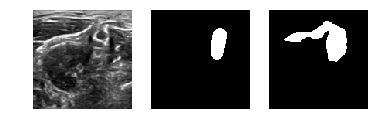

|Iteration 80/2130| TRAIN loss NNG/DISCR: 0.287 / 0.716 || DISCRout REAL / FAKE / NNG: 0.577 / 0.603 / 0.535


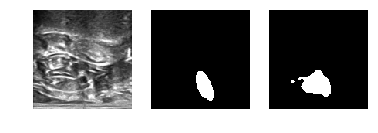

|Iteration 90/2130| TRAIN loss NNG/DISCR: 0.520 / 0.371 || DISCRout REAL / FAKE / NNG: 0.769 / 0.323 / 0.240


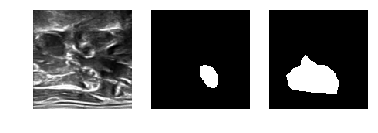

|Iteration 100/2130| TRAIN loss NNG/DISCR: 0.492 / 0.344 || DISCRout REAL / FAKE / NNG: 0.474 / 0.286 / 0.302


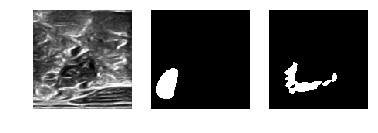

|Iteration 110/2130| TRAIN loss NNG/DISCR: 0.287 / 0.692 || DISCRout REAL / FAKE / NNG: 0.566 / 0.570 / 0.356


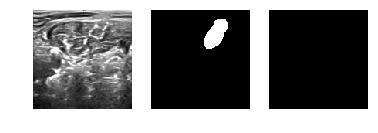

|Iteration 120/2130| TRAIN loss NNG/DISCR: 0.451 / 0.443 || DISCRout REAL / FAKE / NNG: 0.785 / 0.670 / 0.589


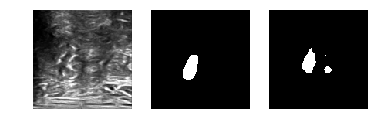

|Iteration 130/2130| TRAIN loss NNG/DISCR: 0.422 / 0.498 || DISCRout REAL / FAKE / NNG: 0.425 / 0.188 / 0.202


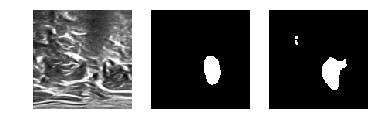

|Iteration 140/2130| TRAIN loss NNG/DISCR: 0.399 / 0.629 || DISCRout REAL / FAKE / NNG: 0.661 / 0.573 / 0.607


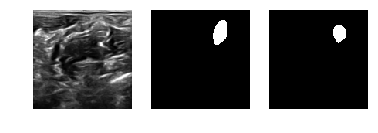

|Iteration 150/2130| TRAIN loss NNG/DISCR: 0.309 / 0.544 || DISCRout REAL / FAKE / NNG: 0.575 / 0.571 / 0.594


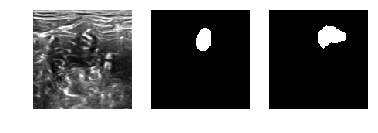

|Iteration 160/2130| TRAIN loss NNG/DISCR: 0.374 / 0.405 || DISCRout REAL / FAKE / NNG: 0.495 / 0.467 / 0.383


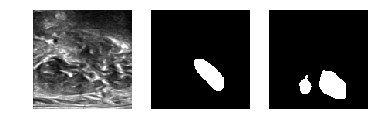

|Iteration 170/2130| TRAIN loss NNG/DISCR: 0.340 / 0.489 || DISCRout REAL / FAKE / NNG: 0.562 / 0.538 / 0.480


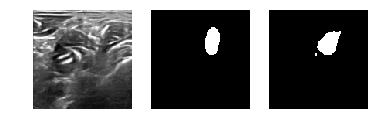

|Iteration 180/2130| TRAIN loss NNG/DISCR: 0.415 / 0.470 || DISCRout REAL / FAKE / NNG: 0.477 / 0.273 / 0.331


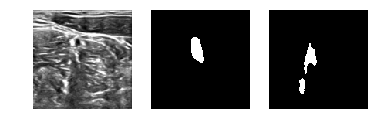

|Iteration 190/2130| TRAIN loss NNG/DISCR: 0.363 / 0.518 || DISCRout REAL / FAKE / NNG: 0.576 / 0.527 / 0.676


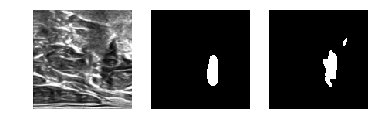

|Iteration 200/2130| TRAIN loss NNG/DISCR: 0.415 / 0.352 || DISCRout REAL / FAKE / NNG: 0.757 / 0.376 / 0.396


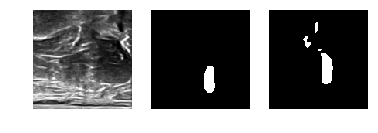

|Iteration 210/2130| TRAIN loss NNG/DISCR: 0.392 / 0.462 || DISCRout REAL / FAKE / NNG: 0.488 / 0.580 / 0.482


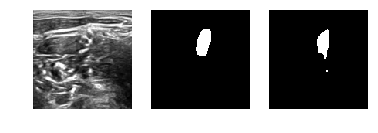

|Iteration 220/2130| TRAIN loss NNG/DISCR: 0.329 / 0.715 || DISCRout REAL / FAKE / NNG: 0.238 / 0.370 / 0.408


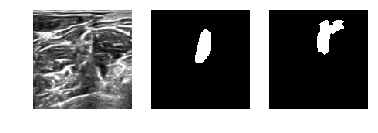

|Iteration 230/2130| TRAIN loss NNG/DISCR: 0.419 / 0.524 || DISCRout REAL / FAKE / NNG: 0.603 / 0.504 / 0.502


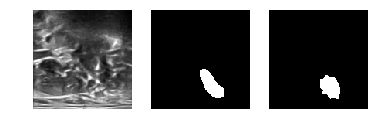

|Iteration 240/2130| TRAIN loss NNG/DISCR: 0.365 / 0.461 || DISCRout REAL / FAKE / NNG: 0.886 / 0.825 / 0.762


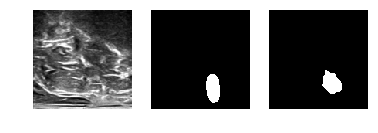

|Iteration 250/2130| TRAIN loss NNG/DISCR: 0.389 / 0.510 || DISCRout REAL / FAKE / NNG: 0.673 / 0.677 / 0.618


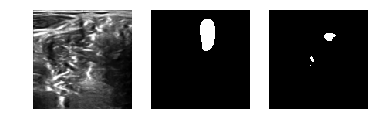

|Iteration 260/2130| TRAIN loss NNG/DISCR: 0.410 / 0.536 || DISCRout REAL / FAKE / NNG: 0.519 / 0.542 / 0.434


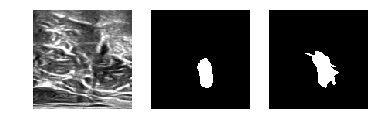

|Iteration 270/2130| TRAIN loss NNG/DISCR: 0.353 / 0.601 || DISCRout REAL / FAKE / NNG: 0.455 / 0.329 / 0.336


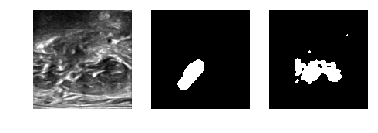

Process Process-2:
Process Process-1:
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib64/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib64/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib64/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **se

KeyboardInterrupt: 

In [9]:
model.binary_out = False
solver = Solver(optim_args={"lr": 0.0005, #0.0025, #1.e-3, #1.e-2
                            "betas": (0.9, 0.999),
                            "eps": 1e-8,
                            "weight_decay": 0.001},
                discr_optim_args={"lr": 0.00025, #0.0025, #1.e-3, #1.e-2
                            "betas": (0.9, 0.999),
                            "eps": 1e-8,
                            "weight_decay": 0.001},
                loss_func = torch.nn.MSELoss())

active_layers = [model.up4, model.up3, model.up2, model.out] #model.bottom is part of binary_out >> dont activate 
model.train()
outputs = solver.train(model, discr_model, train_loader, val_loader, active_layers, log_nth=10, num_epochs=5)

### Test your Model

In [10]:
#Initialize Dataloader
input_dim = (1, 128, 128)
val_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.ToTensor()])
test_data = SegmentationData(img_files,  transform = val_transforms, mode = 'test', **nums)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

In [11]:
model.binary_out = True

#### Plot Single Image

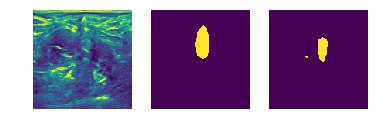

In [12]:
model.eval()

img, targets = test_data[99]

target = targets['main']
inputs = img.unsqueeze(0)
inputs = Variable(inputs)

model=model.cpu()

outputs = model.forward(inputs)
pred = outputs['main']
_, pred = torch.max(pred, 1)
binary_probs, binary = torch.max(outputs['binary'], 1)

#Comment/Uncomment to enable/disable binary classication
if binary.data.numpy() == 0:
    pred = pred * 0
    
pred = pred.squeeze().data.cpu().numpy()
img=np.squeeze(img)
target = target.squeeze().numpy()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(target)
ax[1].axis('off')
ax[2].imshow(pred)
ax[2].axis('off')
plt.show()

#### Are the binary probabilites making sense?
I found it was quite balanced if both values were around 50%. Therefore, train with classweights = [0.25, 0.75] for 5 epochs at least.

In [13]:
outputs['binary']

Variable containing:
 0.3958  0.6042
[torch.FloatTensor of size 1x2]

### Visualize many Images

Set num_example_imgs to whatever you want and modify the slice in test_data[from:to] accordingly.

#### ToDo:
1. Border overlay of mask over image.
2. Filter plots, weights dreaming.
3. ...


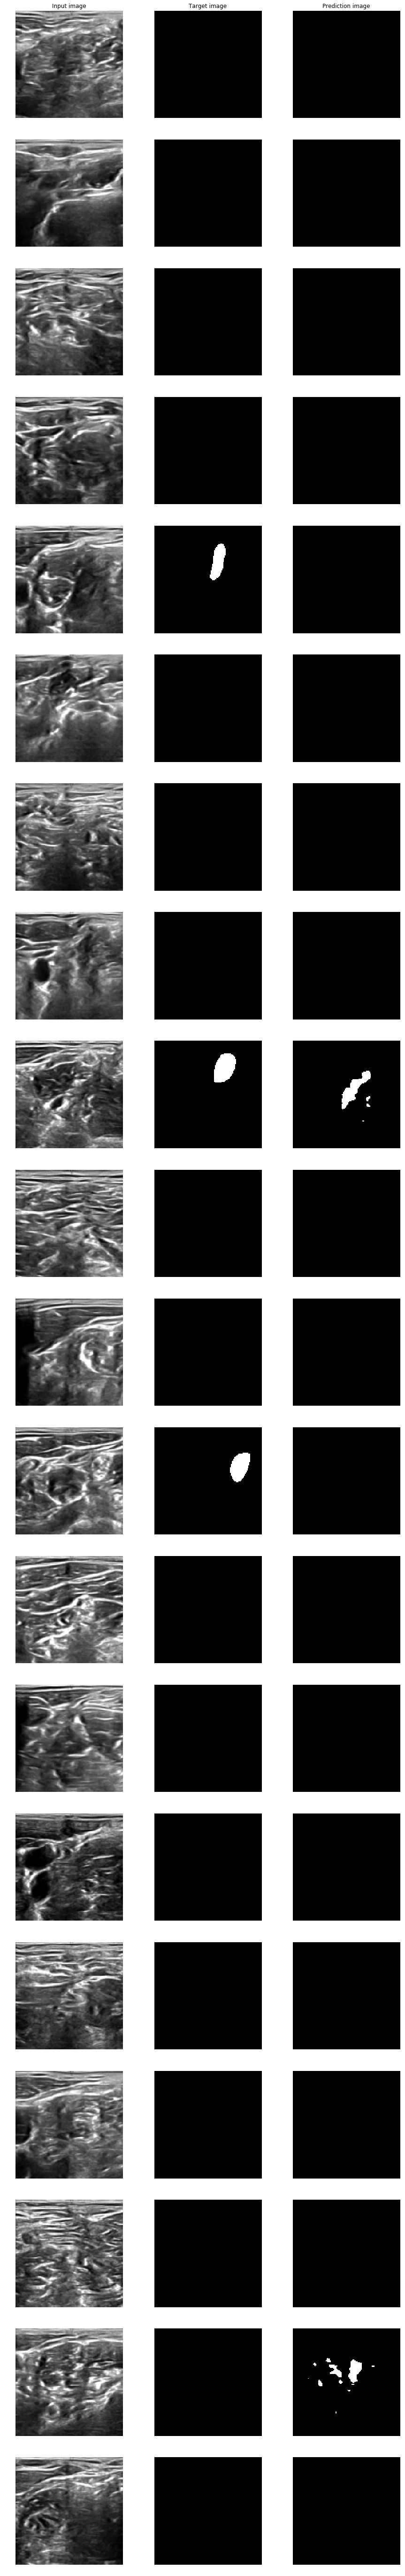

In [14]:
num_example_imgs = 20
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, targets) in enumerate(test_data[70:90]):
    
    target = targets['main']
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)

    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    binary_probs, binary = torch.max(outputs['binary'], 1)
    
    #If binary predicts no nerve we just multiply the predicted image with zeros.
    #Comment/Uncomment and plot to compare with/without of binary classification
    if binary.data.numpy() == 0:
        pred = pred * 0
        
    pred = pred.squeeze().data.cpu().numpy()

    img=np.squeeze(img)
    target = target.squeeze().numpy()
        
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(target, cmap='gray')
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred, cmap='gray')
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

### Dice Coefficient on Testdata

In [15]:
def dice_coefficient(ground_truth, predicted):
    gt = ground_truth
    p = predicted
    if np.sum(p) + np.sum(gt) == 0:
        return 1
    else:
        dice = np.sum(p[gt==1])*2.0 / (np.sum(p*p) + np.sum(gt*gt))
        return dice

test_scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = Variable(inputs), Variable(targets['main'])
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    _, binary = torch.max(outputs['binary'], 1)
    
    #Comment/Uncomment to compare with and without binary classification
    if binary.data.numpy() == 0:
        pred = pred * 0
    
    pred = pred.squeeze().data.cpu().numpy()
    test_scores.append(dice_coefficient(np.squeeze(targets.data.numpy()), pred))
    
np.mean(test_scores)

0.77911123654509928

#### Highscore: score and indice of the best predicted image (with nerve).

In [ ]:
x = np.array(test_scores)
x[x==1] = 0
np.max(x), np.argmax(x)

#### Other Stuff
Calculation of ratios in datasets (interesting for balancing class weights)

In [ ]:
#Total ratio of pixels without/with nerve in dataset
N = 0
mask = 0
for _, (img, target) in enumerate(test_data):
    N += target['main'].numel()
    mask += target['main'].sum()
1 - mask/N, mask/N

In [ ]:
#Total ratio of images without/with nerve in dataset
mask = 0
for _, (img, target) in enumerate(test_data):
    mask += target['main'].sum()>0
1 - mask/len(test_data), mask/len(test_data)

### Stats

In [ ]:
model.eval()
model.binary_out = True

sensitivity, specificity = [0, 0]
stats = {'true_positives': 0, 'false_positives': 0, 'true_negatives': 0, 'false_negatives': 0}

for i in range(test_data.__len__()):
    img, targets = test_data[5]

    target = targets['main']
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)

    model=model.cpu()
    img=np.squeeze(img)
    target = target.squeeze().numpy()
    
    outputs = model.forward(inputs)
    _, binary_out = torch.max(outputs['binary'], 1)
    threshold = float(binary_out)
    
    pred = outputs['main'].squeeze().data.cpu().numpy()
    pred_post_threshold = pred
    value_present = 1
    pred_post_threshold[pred_post_threshold < threshold] = 0
    pred_post_threshold[pred_post_threshold >= threshold] = value_present
    
    
    target_present = value_present in target
    pred_present = value_present in pred_post_threshold
    
    if target_present and pred_present:
        stats['true_positives'] += 1 
    elif not target_present and pred_present:
        stats['false_positives'] += 1
    elif not target_present and not pred_present:
        stats['true_negatives'] += 1
    elif target_present and not pred_present: 
        stats['false_negatives'] += 1
    
if((stats['true_positives'] + stats['false_negatives']) > 0):
    sensitivity = stats['true_positives'] / (stats['true_positives'] + stats['false_negatives'])
if((stats['true_negatives'] + stats['false_positives']) > 0):
    specificity = stats['true_negatives'] / (stats['true_negatives'] + stats['false_positives'])

print("Stats %s \n Sensitivity: %s \n Specificity: %s" % (stats, sensitivity, specificity)) 